# Mammogram mass: benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Goal

The goal is to find the ML method that achieves the highest accuracy in predicting whether a mass is benign or malignant.

To achieve this, a few steps were followed:
1. Exploratory Data Analysis
2. Data Pre-processing
3. Apply different supervised machine learning methods

The methods include:
* Decision Tree
* Random Forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* Neural Network

## Import libraries and load data

In [111]:
%pip install pydotplus
%pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns           
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

from IPython.display import Image  
from six import StringIO  
import pydotplus

In [78]:
masses_data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [79]:
masses_data.to_csv('out.csv')

## 1. Exploratory Data Analysis (EDA)


### 1.1 High-level Description

The `masses_data` dataset comprises 961 entries and 6 columns. While the dataset contains 961 entries, not all columns are fully populated:

- **BI-RADS**: 959 non-null entries
- **age**: 956 non-null entries
- **shape**: 930 non-null entries
- **margin**: 913 non-null entries
- **density**: 885 non-null entries 

The target variable, `severity`, however, is complete with 961 entries.

Statistical insights reveal that the average age of patients in the dataset is approximately 55.5 years. For categorical variables such as `shape`, `margin`, `density`, and `BI-RADS`, the mode provides more meaningful insights:

- **BI-RADS**: Mode = 4.0
- **shape**: Mode = 4.0
- **margin**: Mode = 1.0
- **density**: Mode = 3.0

From the data, the mean of the `severity` column is approximately 0.463, highlighting that the dataset is fairly balanced in terms of benign (0) and malignant (1) classifications.

From a datatype perspective, five columns hold `float64` type data while `severity` (target) contains `int64` values. This dataset presents a mix of continuous and categorical data, with certain missing entries that might require preprocessing before analysis or modeling.


In [3]:
masses_data.shape

(961, 6)

In [4]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [5]:
masses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [6]:
masses_data.dtypes

BI-RADS     float64
age         float64
shape       float64
margin      float64
density     float64
severity      int64
dtype: object

In [7]:
# Get the mode for each variable
masses_data.mode().iloc[0]

BI-RADS      4.0
age         59.0
shape        4.0
margin       1.0
density      3.0
severity     0.0
Name: 0, dtype: float64

### 1.2 Drop irrelevant columns
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.


In [8]:
masses_data = masses_data.drop(['BI-RADS'], axis=1)
masses_data.head(5)

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


### 1.3 Missing Values

The dataset has missing values in several columns, most notably in density (7.9%), followed by margin, shape, and age. There are no missing values in the severity column. We identified 130 rows with at least one missing value, some of which had more than one missing attribute. Prior to handling these, the severity distribution was 53.69% benign (0) and 46.31% malignant (1). After deciding to eliminate these rows, we were left with 831 records. Importantly, this action improved the balance of the dataset to 51.50% benign and 48.50% malignant.

In [9]:
# Number of MV per feature
masses_data.isnull().sum()

age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

In [10]:
# Percentage of MV per feature
(masses_data.isnull().sum()/(len(masses_data)))*100

age         0.520291
shape       3.225806
margin      4.994797
density     7.908429
severity    0.000000
dtype: float64

In [11]:
# Check the rows with a least one missing value
masses_data[masses_data.isnull().any(axis=1)]

,age,shape,margin,density,severity
1,43.0,1.0,1.0,NaN,1
4,74.0,1.0,5.0,NaN,1
5,65.0,1.0,NaN,3.0,0
6,70.0,NaN,NaN,3.0,0
7,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...
778,60.0,NaN,4.0,3.0,0
819,35.0,3.0,NaN,2.0,0
824,40.0,NaN,3.0,4.0,1
884,NaN,4.0,4.0,3.0,1


In [12]:
# Check how balanced the dataset is
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    53.694069
1    46.305931
Name: severity, dtype: float64

In [13]:
# Drop the rows with missing values
masses_data = masses_data.dropna()
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


In [14]:
# Check how dropping the rows with MV affected the balance of the dataset
masses_data['severity'].value_counts()
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    51.504212
1    48.495788
Name: severity, dtype: float64

### 1.4 Univariate Analysis

When analyzing continuous variables like 'Age', we utilize visualization tools such as histograms and box plots to get an insightful view of the distribution and spread. For categorical variables like 'Shape', 'Margin', and 'Density', count plots are employed to offer a clear representation of the frequency distribution.

Upon examining the visualizations, several key observations emerge:

- Outliers: There aren't any noticeable outliers across the features, signifying the cleanliness of the dataset in terms of anomalies.
- Age: The data indicates that ages range between 18 and 96, which fits within a logical and expected range.
- Categorical Variables: Every value observed for these variables resides comfortably within their domain.
- Target Variable (Severity): This specific variable holds only binary values, thus confirming its integrity.

Concluding our analysis, the data appears to be in good shape, especially concerning outliers, suggesting there's no immediate need for outlier-specific data processing.

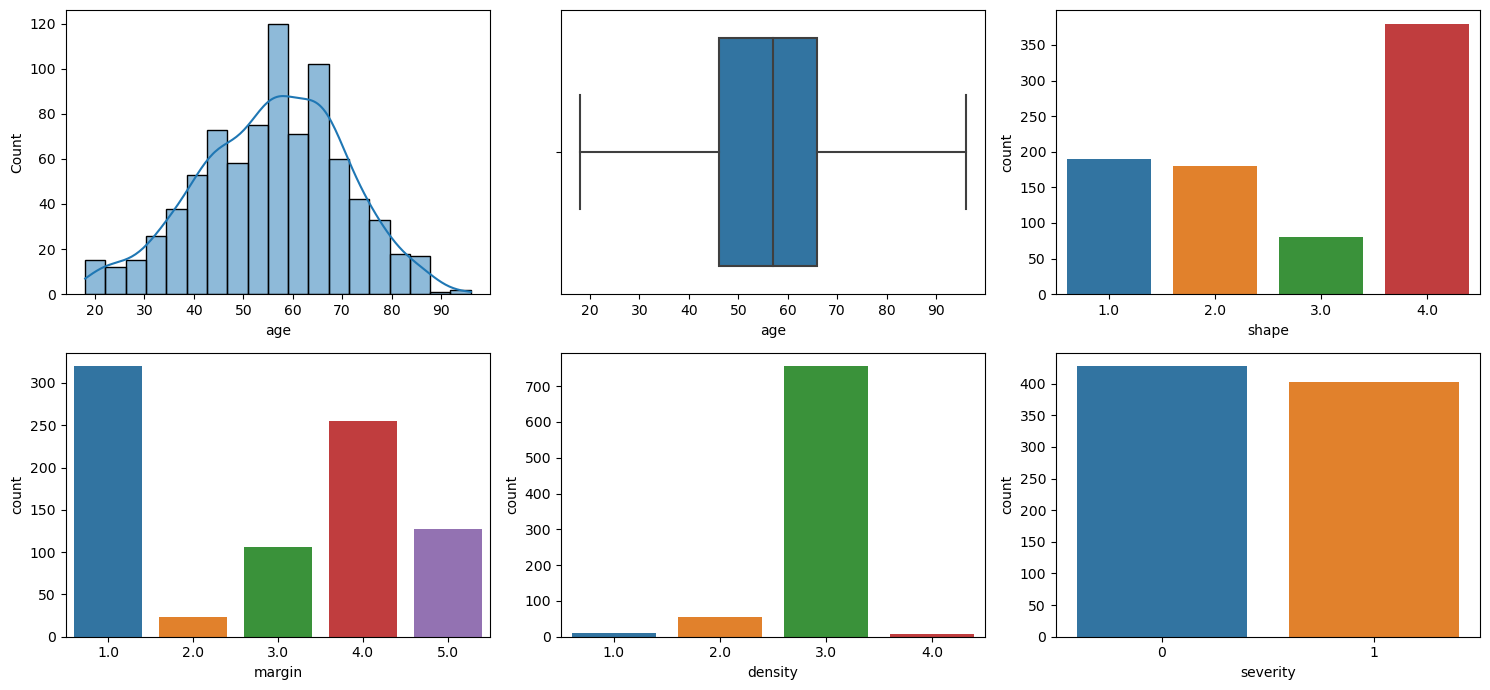

In [15]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
sns.histplot(masses_data['age'], kde=True)

plt.subplot(2, 3, 2)
sns.boxplot(x='age', data=masses_data)

plt.subplot(2, 3, 3)
sns.countplot(x='shape', data=masses_data)

plt.subplot(2, 3, 4)
sns.countplot(x='margin', data=masses_data)

plt.subplot(2, 3, 5)
sns.countplot(x='density', data=masses_data)

plt.subplot(2, 3, 6)
sns.countplot(x='severity', data=masses_data)

plt.tight_layout()

plt.show()

### 1.4 Multivariate Analysis

#### 1.4.1 Correlation 
Shape and margin have the highest correlation (0.74) and they are also the ones with the highest correlation with the target variable, followed by age. This suggests they will have an import role in predicting whether the mass is malignant or benign.

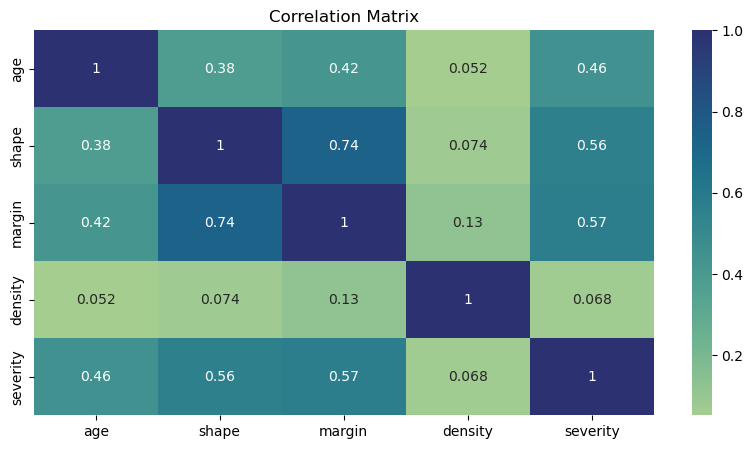

In [16]:
plt.figure(figsize=(10,5))
c= masses_data.corr()
sns.heatmap(c,cmap="crest",annot=True)
plt.title("Correlation Matrix")
plt.show()

#### 1.4.2 Relationship with the Target Variable

A discernible trend is that individuals with malignant masses tend to be older. Moreover, when examining the features of `shape` and `margin`, we find that benign masses are often characterized by lower values, while malignant masses typically exhibit higher values. This implies that elevated values in these features could be strong indicators of malignancy. Conversely, the `density` feature appears to have a negligible influence on the severity prediction, given the consistent outcomes across its different values.

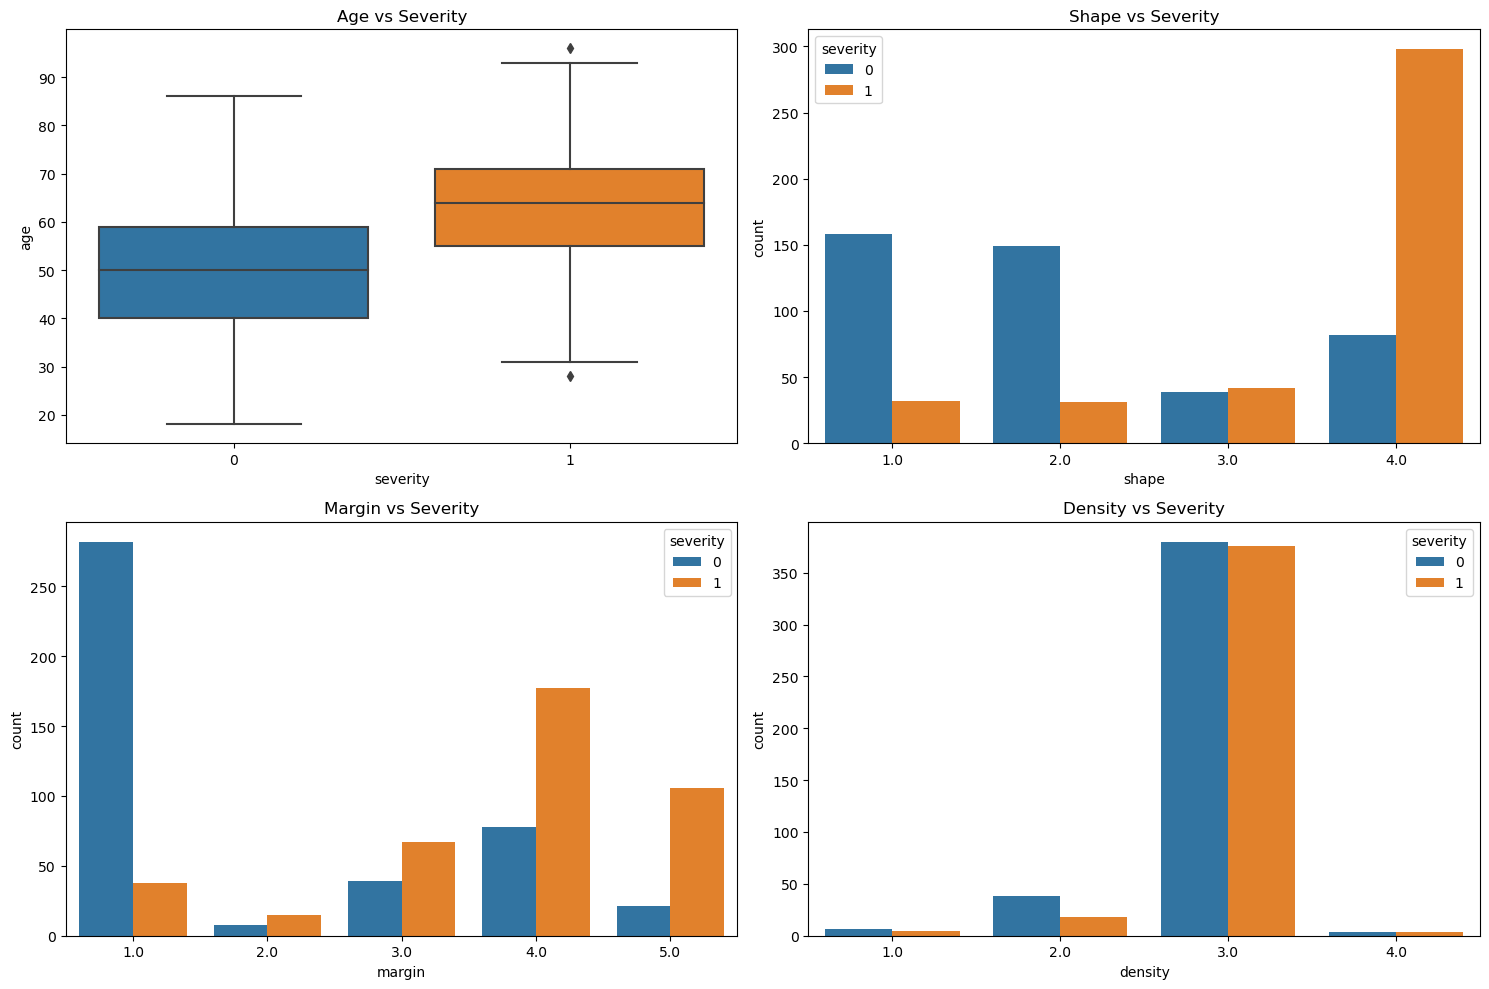

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=masses_data, x="severity", y="age")
plt.title("Age vs Severity")

plt.subplot(2, 2, 2)
sns.countplot(data=masses_data, x="shape", hue="severity")
plt.title("Shape vs Severity")

plt.subplot(2, 2, 3)
sns.countplot(data=masses_data, x="margin", hue="severity")
plt.title("Margin vs Severity")

plt.subplot(2, 2, 4)
sns.countplot(data=masses_data, x="density", hue="severity")
plt.title("Density vs Severity")

plt.tight_layout()

plt.show()

### 1.5 Conclusions
- 130 rows were removed due to missing values
- The `BI-RADS` column was removed
- No outliers
- `shape`, `margin` and `age` look like the most relevant predictors of severity
- 831 instances, 4 features, 1 target. 

In [18]:
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


## 2. Pre-Processing

### 2.1 Scaling/Normalization
Feature scaling ensures all input features have the same scale or range. In the context of this project, scaling plays a pivotal role for certain algorithms.

- **SVM & Neural Networks**: Scaled features drive a smoother and faster optimization process.
- **kNN**: Being a distance-based algorithm, scaling ensures that no feature overshadows others because of its range.
- **Logistic Regression**: when regularization is applied, scaling can be beneficial.

On the flip side, some models are relatively indifferent to feature scaling:
- **Tree-Based Models**: Algorithms like *Decision Trees*, *Random Forests*, and *XGBoost* prioritize feature importance over absolute scale.
- **Naive Bayes**: Its probabilistic nature tends to be less swayed by the scale of input features.

Lastly, if a feature's magnitude is meaningful and essential for interpretability, scaling might warrant a second thought.

In [19]:
X = masses_data.drop('severity', axis=1)
y = masses_data['severity']

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
X_scaled_min_max = scaler.fit_transform(X)

### 2.2 Split Dataset

In [112]:
# The normal dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The dataset scaled with Standard Scaler
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The dataset scaled with Min Max Scaler
X_train_scaled_min_max, X_test_scaled_min_max, y_train, y_test = train_test_split(X_scaled_min_max, y, test_size=0.2, random_state=42)

## 3. Model Building, Optimization and Evaluation

In this section, we'll dive into the practical part of our project — building, tweaking, and testing different predictive models. We're using a variety of machine learning algorithms to see which one can best predict whether a mammogram mass is benign or malignant. Our process is straightforward: build the initial models, adjust their settings for better performance, and then check how well they do. Our goal is simple: find the model that gives us the most accurate results. Throughout this process, we're using `accuracy` as our main metric for evaluation, which works well for our balanced dataset. 

### 3.1 Logistic Regression

#### 3.1.1 Initial Model Evaluation

In [130]:
# Initialize the classifier
clf = LogisticRegression(random_state=0)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy:.2f}")

Accuracy on Test Data: 0.78


In [114]:
# Using cross-validation
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8051 (+/- 0.08)


#### 3.1.2 Hyperparameter Tuning

In [119]:
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

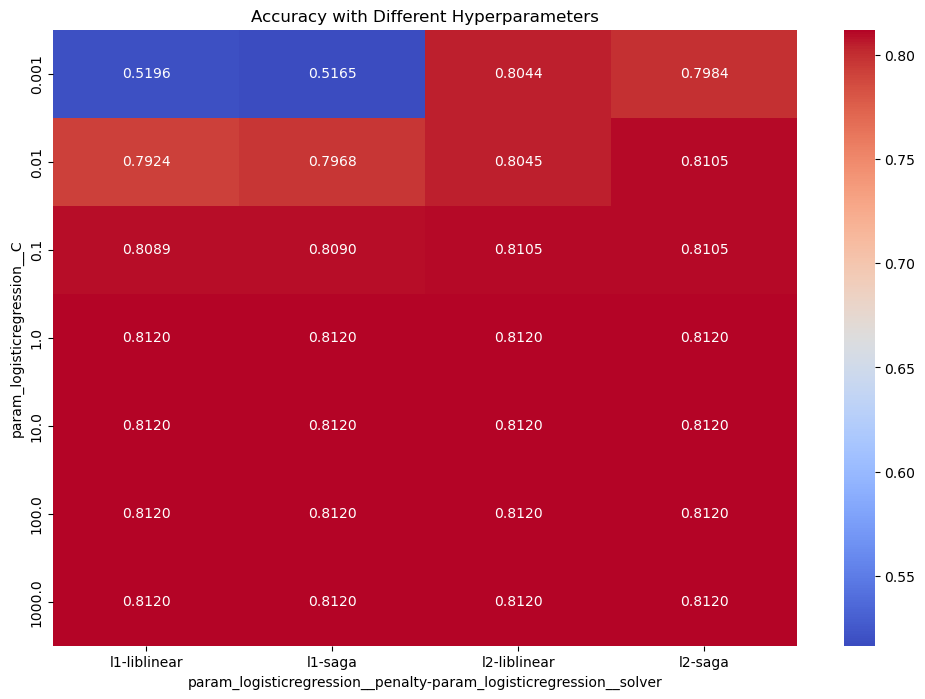

In [120]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_logisticregression__C', 
    columns=['param_logisticregression__penalty', 'param_logisticregression__solver'], 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [126]:
# Show the accuracy on training data and the best parameters
print("Best Parameters:", grid_search.best_params_)
print(f"\nAccuracy on Training Data: {grid_search.best_score_:.4f}")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy:.4f}")

Best Parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

Accuracy on Training Data: 0.8120
Accuracy on Test Data: 0.7784


#### Analyse Feature Importance

   Feature  Coefficient
1    shape     0.837776
0      age     0.830829
2   margin     0.647950
3  density    -0.054076


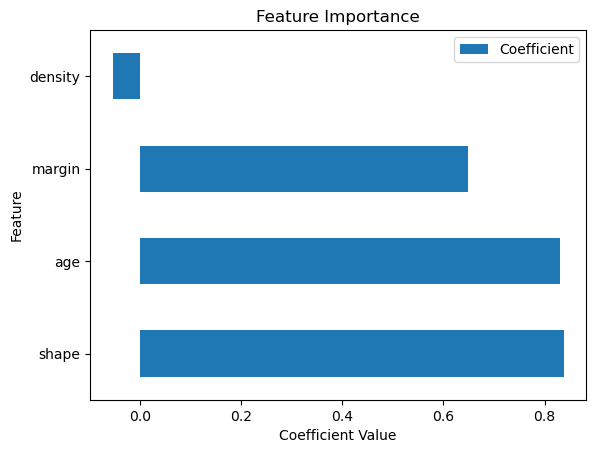

In [129]:
best_model = grid_search.best_estimator_

# Extract the logistic regression model from the best model
lr = best_model.named_steps['logisticregression']

# Get the feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Get the coefficients from the logistic regression model
coefficients = lr.coef_[0]

# Combine feature names and coefficients into a dataframe
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by the absolute value of their coefficients
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)

coef_df.plot(kind='barh', x='Feature', y='Coefficient')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### 3.2 Naive Bayes

#### 3.2.1 Build and Evaluate Model

In [54]:
# Initialize the classifier
clf = MultinomialNB()

# Fit the classifier with training data
clf.fit(X_train_scaled_min_max, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled_min_max)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [55]:
# Using cross-validation
clf = MultinomialNB()
scores = cross_val_score(clf, X_scaled_min_max, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7810 (+/- 0.11)


In [56]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

#### 3.2.2 Hyperparameter Tuning

In [80]:
# Define the parameter grid to search
param_grid = {'multinomialnb__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]}

# Create the pipeline
pipeline = make_pipeline(MinMaxScaler(), MultinomialNB())  # Increased max_iter for convergence

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5,
                                                  1.0, 10.0]},
             scoring='accuracy', verbose=1)

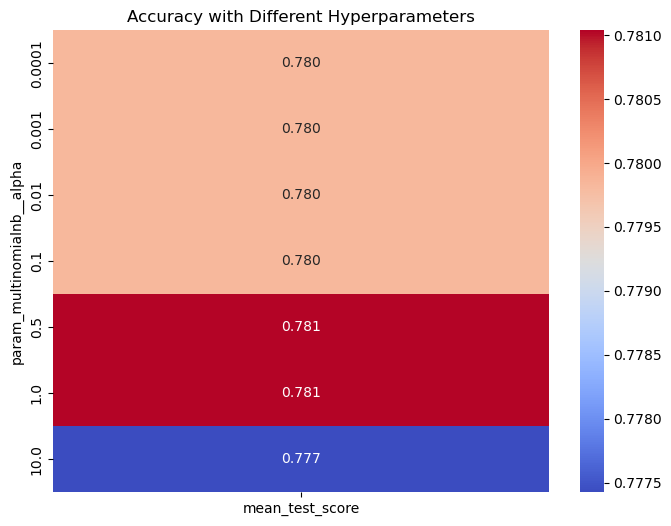

In [74]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_multinomialnb__alpha', 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [75]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Best Parameters: {'multinomialnb__alpha': 0.5}
Best Cross-Validation Score: 0.7810


### 3.3 kNN

#### 3.3.1 Build and Evaluate Model

In [138]:
# Initialize the classifier
clf = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier with training data
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


In [139]:
# Using cross-validation
clf = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(clf, X_scaled, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7858 (+/- 0.10)


#### 3.3.2 Hyperparameter Tuning

In [108]:
# Define the parameter grid to search
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1,20)),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1)

# Fit the model (assuming you have data prepared in X_train and y_train)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18,
                                                               19]},
             scoring='accuracy', verbose=1)

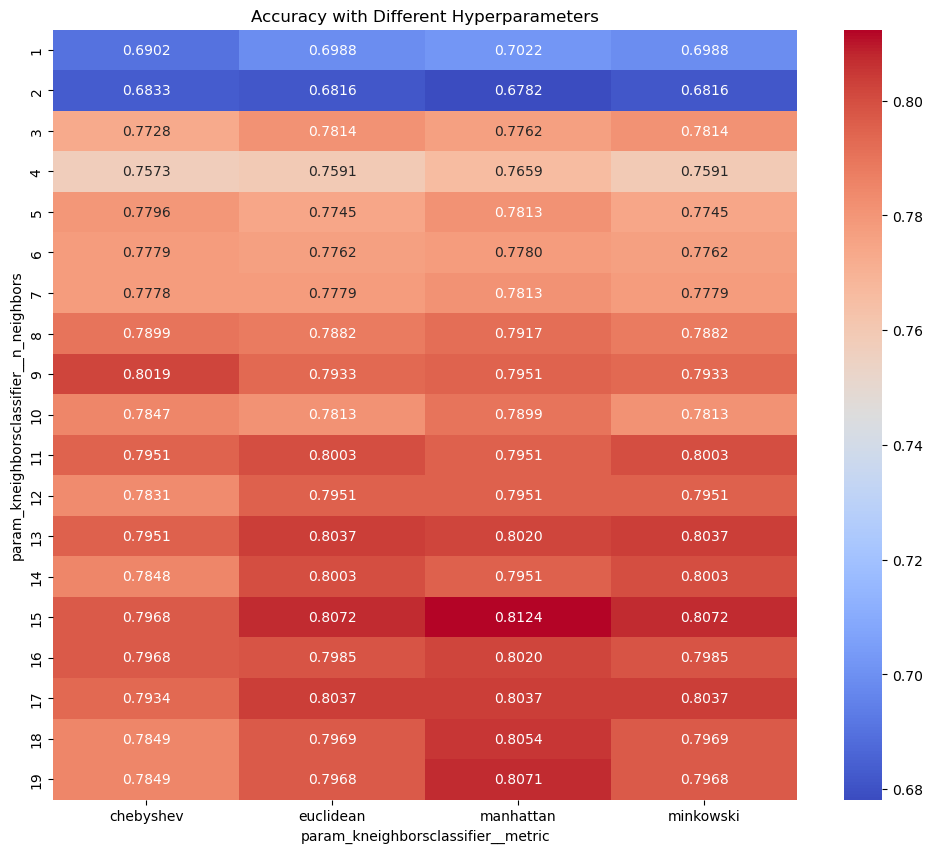

In [109]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_kneighborsclassifier__n_neighbors', 
    columns=['param_kneighborsclassifier__metric'], 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [110]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Best Parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 15}
Best Cross-Validation Score: 0.8124
Accuracy on Test Data: 0.788


### 3.4 Decision Trees

#### 3.4.1 Build and Evaluate Model

In [141]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [142]:
# Initialize the classifier
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7955 (+/- 0.07)


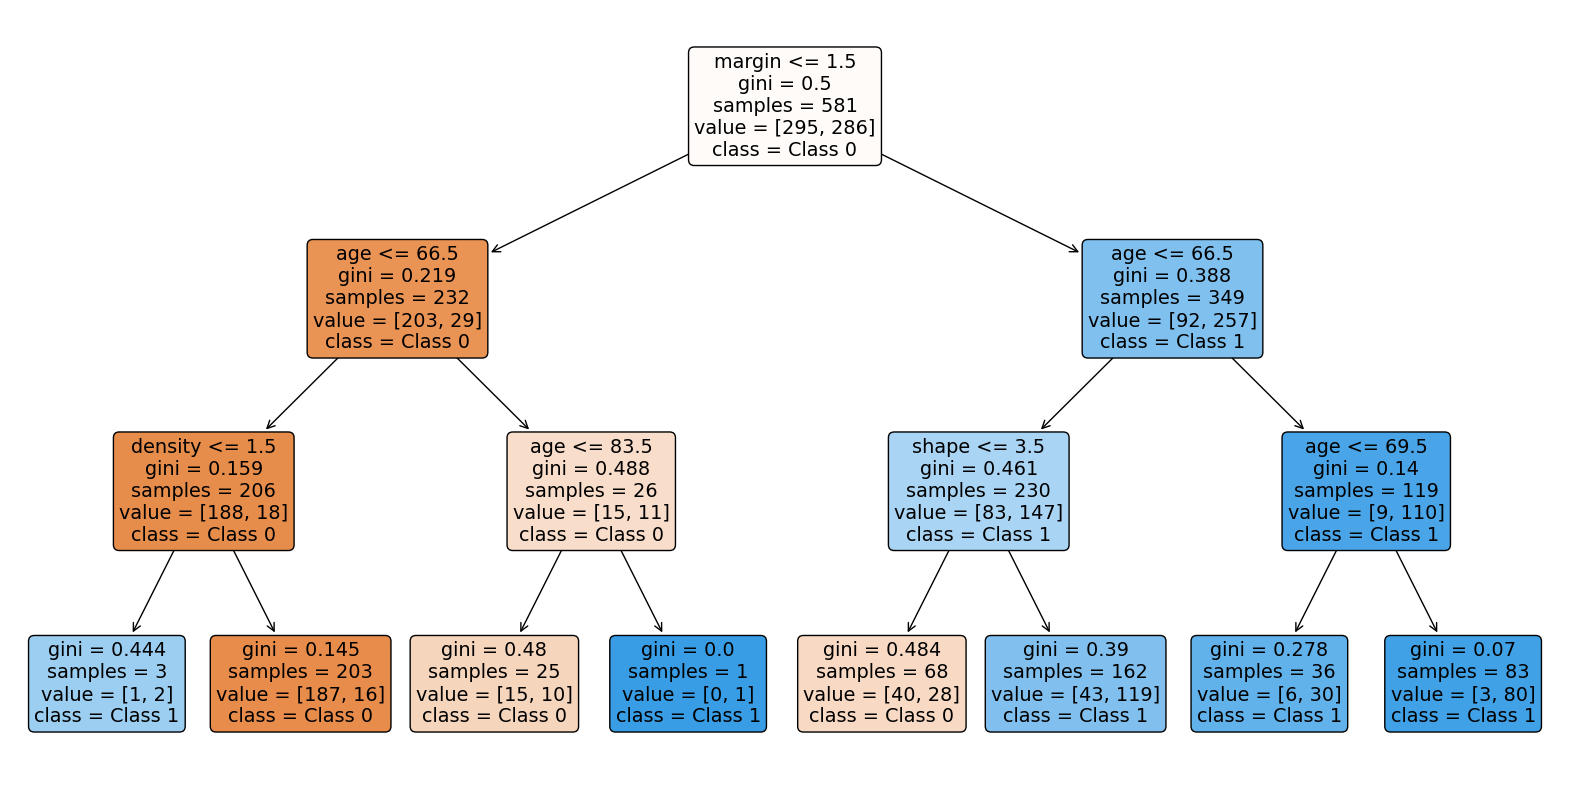

In [143]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns.tolist(), class_names=["Class 0", "Class 1"], rounded=True)
plt.show()

#### 3.4.2 Hyperparameter Tuning

### 3.5 Ensemble Methods

#### 3.5.1 Random Forest

##### 3.5.1.1 Build and Evaluate Model

In [144]:
# Initialize the classifier
clf = RandomForestClassifier(n_estimators=8)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


In [145]:
clf = RandomForestClassifier(n_estimators=8)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7437 (+/- 0.09)


##### 3.5.1.2 Hyperparameter Tuning

#### 3.5.2. XGBoost

##### 3.5.2.1 Build and Evaluate Model

In [146]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 3} 
epochs = 10 

model = xgb.train(param, train, epochs)
predictions = model.predict(test)

accuracy_score(y_test, predictions)

0.8

In [147]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
scores = cross_val_score(xgb_classifier, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.07)


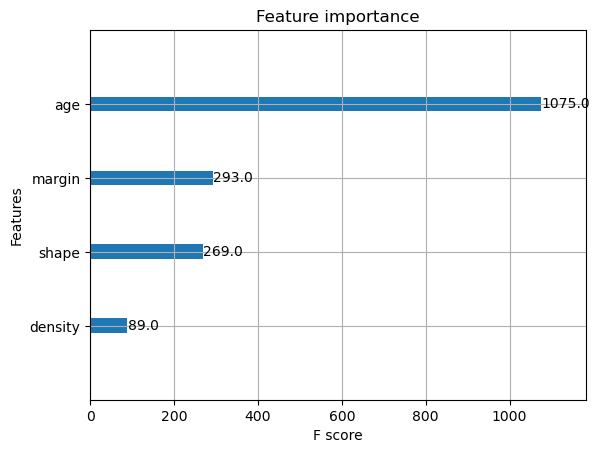

In [148]:
# Fit the model to the entire dataset
xgb_classifier.fit(X, y)

# Plot feature importances
xgb.plot_importance(xgb_classifier)
plt.show()

##### 3.5.2.2 Hyperparameter Tuning

### 3.6 Support Vector Machines (SVM)

#### 3.6.1 Build and Evaluate Model

In [149]:
clf = SVC()
scores = cross_val_score(clf, X_scaled, y, cv=10, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8003 (+/- 0.08)


In [150]:
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['auto', 'scale', 0.1, 1, 10, 100]
}

pipeline = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Cross-Validation Score: 0.8075174951302216


#### 3.6.2 Hyperparameter Tuning

### 3.7 Neural Networks

#### 3.7.1 Scikit-learn

In [ ]:
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlpclassifier__activation': ['logistic', 'relu', 'tanh'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'mlpclassifier__learning_rate': ['constant', 'adaptive']
}

pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=10, random_state=42))

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

#### 3.7.2 Tensorflow

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

cv_scores = cross_val_score(estimator, X_scaled, y, cv=10)
cv_scores.mean()

#### 3.7.3 PyTorch

## 4. Conclusions

Best model, etc..